In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
# import pandas as pd
import json
from src.problem import Instance

/home/bruno/miniconda3/envs/sat-gnn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
instances_dir = Path('../data/raw/')
results_dir = Path('../data/results/')
opts_dir = Path('../data/interim')

instances = list()
for fp in instances_dir.glob('*_*_*.json'):
    T, J, i = fp.name[:-len('.json')].split('_')
    instances.append(dict(
        T=int(T),
        J=int(J),
        i=int(i),
        mtime=fp.stat().st_mtime,
    ))

# df = pd.DataFrame([fp.name[:-len('.json')].split('_') for fp in instances_dir.glob('*_*_*.json')], columns=('T', 'J', 'i'))
df = pd.DataFrame(instances)
df['mtime'] = pd.to_datetime(df['mtime'], unit='s')
# df = df[df['i'] <= 100]
df.groupby(['T', 'J'])['i'].nunique()

T    J 
97   9     207
     13    203
     18    205
     20     46
     22     45
     24     45
125  9     206
     13    207
     18    203
     20     44
     22     42
     24     45
Name: i, dtype: int64

In [17]:
from src.dataset import SolutionFeasibilityDataset

# ds = SolutionFeasibilityDataset(list(instances_dir.glob('125_9_*.json')), sols_dir=opts_dir)
# ds.maybe_initialize()
# ds.save_dataset('test.hdf5')
ds = SolutionFeasibilityDataset.from_file_lazy('../data/processed/feasibility_125_train.hdf5')
len(ds)

3000

In [19]:
%timeit ds[np.random.randint(0,len(ds))]

18.7 ms ± 69.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
ds = SolutionFeasibilityDataset(
    # [fp for fp in Path('data/raw/').glob('125_*.json') if (int(fp.name.split('_')[1]) < 20) and (int(fp.name.split('_')[2].replace('.json', '')) < 200)],
    [fp for fp in Path('../data/raw/').glob('125_*.json') if (int(fp.name.split('_')[1]) < 20) and (int(fp.name.split('_')[2].replace('.json', '')) < 1)],
)
ds.maybe_initialize()

  0%|          | 0/3 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-14
wrote problem to file /home/bruno/sat-gnn/notebooks/model.cip
wrote problem to file /home/bruno/sat-gnn/notebooks/model.cip


 33%|███▎      | 1/3 [00:58<01:56, 58.36s/it]

wrote problem to file /home/bruno/sat-gnn/notebooks/model.cip
wrote problem to file /home/bruno/sat-gnn/notebooks/model.cip


 67%|██████▋   | 2/3 [02:17<01:10, 70.48s/it]

wrote problem to file /home/bruno/sat-gnn/notebooks/model.cip
wrote problem to file /home/bruno/sat-gnn/notebooks/model.cip


100%|██████████| 3/3 [02:52<00:00, 57.53s/it]


In [24]:
%timeit ds[np.random.randint(0,len(ds))]

834 µs ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
ds[0]

/home/bruno/sat-gnn/notebooks/../src/dataset.py:169: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if k is not 'kwargs':
/home/bruno/sat-gnn/notebooks/../src/dataset.py:169: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if k is not 'kwargs':
/home/bruno/sat-gnn/notebooks/../src/dataset.py:169: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if k is not 'kwargs':
/home/bruno/sat-gnn/notebooks/../src/dataset.py:169: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if k is not 'kwargs':
/home/bruno/sat-gnn/notebooks/../src/dataset.py:169: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if k is not 'kwargs':
/home/bruno/sat-gnn/notebooks/../src/dataset.py:169: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if k is not 'kwargs':
/home/bruno/sat-gnn/notebooks/../src/dataset.py:169: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if k is not 'kwargs':
/home/bruno/sat-gnn/notebooks/../src/dataset.py:

TypeError: expected np.ndarray (got list)

In [9]:
del ds
ds = SolutionFeasibilityDataset.from_file_lazy('test.hdf5')

14000

In [14]:
!rm test.hdf5*

In [26]:
import dgl
dgl.save_graphs('test.hdf5', [ds.gs[3000], ds.gs[4000], ds.gs[5000]])

In [27]:
dgl.load_graphs('test.hdf5', [2])

([Graph(num_nodes={'con': 7338, 'soc': 375, 'var': 2250},
        num_edges={('con', 'c2s', 'soc'): 999, ('con', 'c2v', 'var'): 95419, ('soc', 's2c', 'con'): 999, ('var', 'v2c', 'con'): 95419},
        metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')])],
 {})

In [28]:
import h5py

with h5py.File('test.hdf5', 'r') as f:
    print(list(f.keys()))

OSError: Unable to open file (file signature not found)

In [39]:
import re

candidate_values = sols[0][instance.vars_names.find('x(') >= 0]
candidate = dict(zip(instance.vars_names[instance.vars_names.find('x(') >= 0],
                     sols[0][instance.vars_names.find('x(') >= 0]))

X = np.zeros((instance.jobs, instance.T), dtype='uint8')
for var_name, var_x in candidate.items():
    j, t = re.fullmatch(r"x\((\d+),(\d+)\)", var_name).groups()
    j = int(j)
    t = int(t)
    X[j,t] = np.round(var_x)

Phi = X.copy()
Phi[:,1:] = np.where(X[:,1:] - X[:,:-1] != 0, X[:,1:], np.zeros_like(X[:,1:]))

In [44]:
actual_phi = sols[0][instance.vars_names.find('phi(') >= 0]

np.isclose(actual_phi, Phi.flatten(), atol=1e-6).all()

(array([5.47495326e-07, 5.50273625e-07]), array([0, 0], dtype=uint8))

True

In [32]:
Phi[5][:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

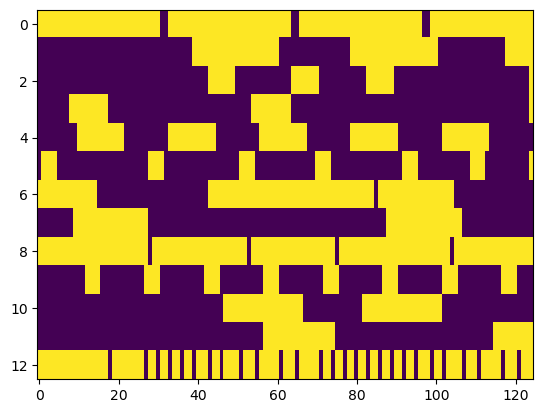

In [33]:
plt.imshow(X, aspect='auto')

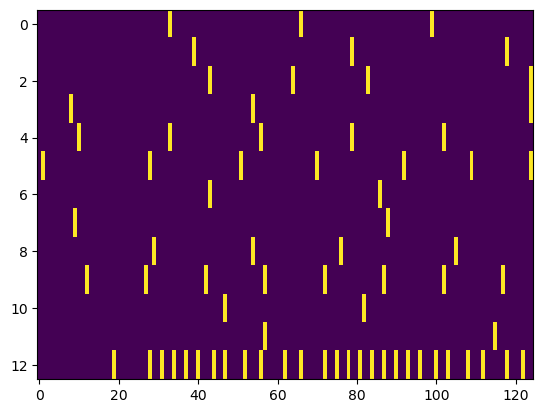

In [34]:
plt.imshow(Phi, aspect='auto')

In [6]:
sols_fp = opts_dir/(fp.name.replace('.json', '_sols.npz'))
sols = np.load(sols_fp)['arr_0']
sols.shape

FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/125_13_14_sols.npz'

In [7]:
sols[np.random.choice(np.arange(sols.shape[0]))]

array([ 1.,  1.,  1., ...,  1.,  0., -0.])

In [5]:
n_sols = list()
for fp in instances_dir.glob('125_*_*.json'):
    sols_fp = opts_dir/(fp.name.replace('.json', '_sols.npz'))
    try:
        sols = np.load(sols_fp)['arr_0']
        if len(sols) == 0:
            print(fp)
        else:
            n_sols.append(len(sols))
    except FileNotFoundError:
        pass

min(n_sols), np.mean(n_sols), max(n_sols)

(500, 500.0, 500)

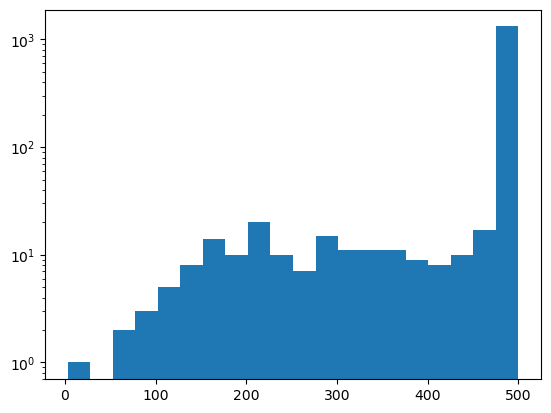

[3, 68, 76, 90, 94]

In [26]:
plt.hist(n_sols, bins=20)
plt.yscale('log')
plt.show()
sorted(n_sols)[:5]

In [73]:
next(zip(sols, np.ones(len(sols), dtype='uint8')))

(array([ 1.,  1.,  1., ...,  1., -0., -0.]), 1)

In [8]:
instance = Instance.from_file(fp)

sols_fp = opts_dir/(fp.name.replace('.json', '_sols.npz'))
sols = np.load(sols_fp)['arr_0']

with instance.to_gurobipy(coupling=False, new_inequalities=False) as m:
    vars_names = np.core.defchararray.array([v.VarName for v in m.getVars()])
    vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

def random_candidate_from_sols(sols, vars_names, n_noise=1):
    # only x values, to avoid infeasibility due to x being different from phi
    x = sols[np.random.choice(np.arange(sols.shape[0]))][vars_names.find('x(') >= 0]

    if n_noise == 1:
        noise = np.eye(len(x))[np.random.choice(np.arange(len(x)))]
    else:
        p = n_noise / len(x)
        noise = np.random.choice([False, True], size=len(x), p=[1-p, p])

    x_dirty = np.where(noise, 1 - x, x)
    candidate = dict(zip(vars_names[vars_names.find('x(') >= 0], x_dirty))

    return candidate


model = instance.to_scip(coupling=True, new_inequalities=True,
                        enable_primal_dual_integral=False)
candidate = random_candidate_from_sols(sols, vars_names)
# while not instance._fix_vars_and_solve(model, candidate):
#     model = instance.to_scip(coupling=True, new_inequalities=True,
#                             enable_primal_dual_integral=False)
#     candidate = random_candidate_from_sols(sols, vars_names)

In [32]:
p = 5 / len(x)
noise = np.random.choice([False, True], size=len(x), p=[1-p, p])
x_dirty = np.where(noise, 1 - x, x)


(4, 4.0)

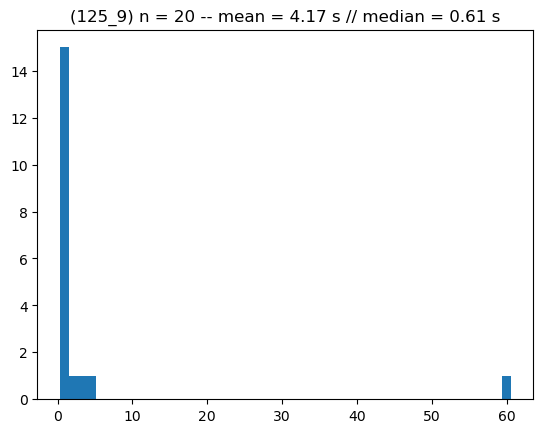

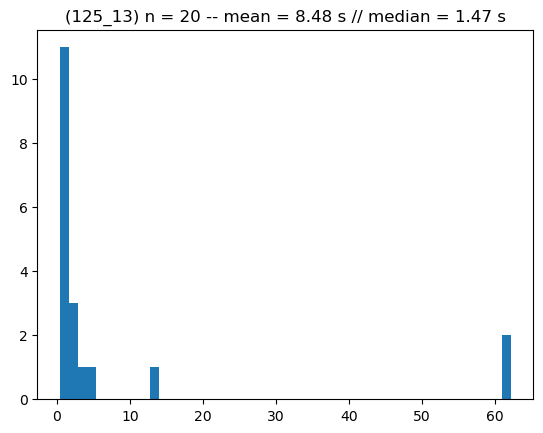

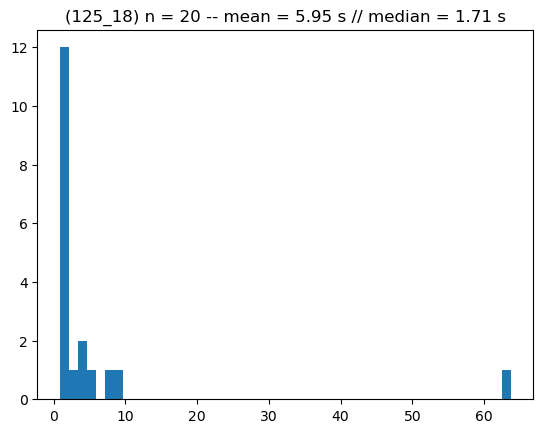

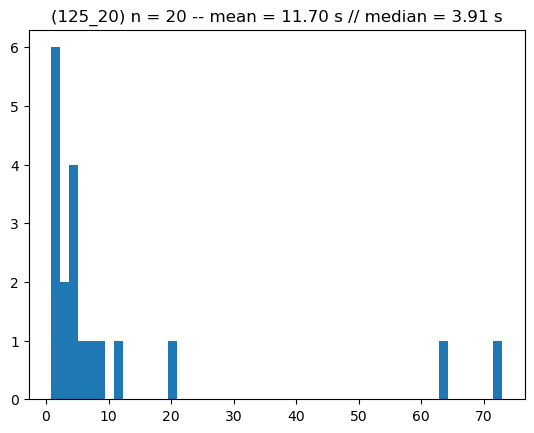

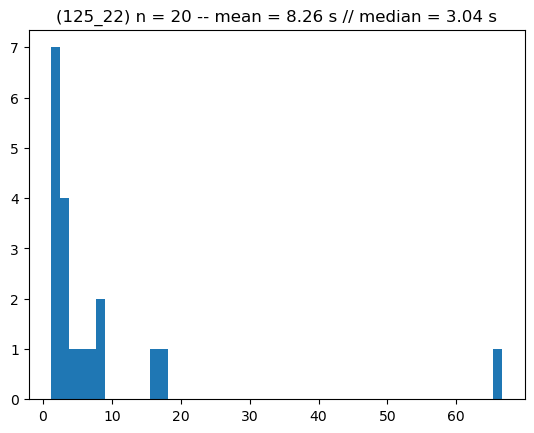

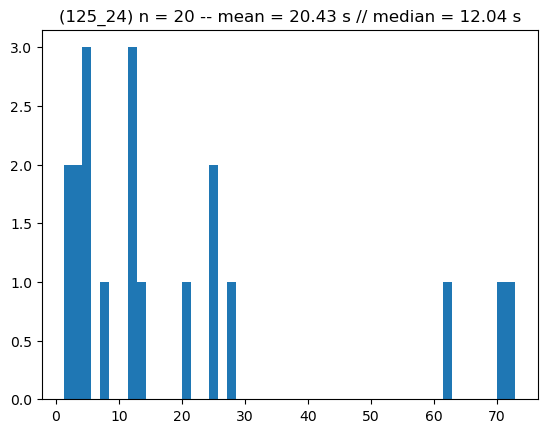

In [20]:
for T in sorted(df['T'].unique()):
    df_ = df[df['T'] == T]
    for J in sorted(df_['J'].unique()):
        df__ = df_[df_['J'] == J]

        df__ = df__.sort_values('mtime')
        timesteps = (df__['mtime'] - df__['mtime'].shift(1)).dropna()
        # timesteps = timesteps[timesteps < 1e3 * timesteps.median()]
        # timesteps = timesteps[timesteps < np.mean(timesteps) + np.std(timesteps)]

        plt.hist(timesteps.dt.total_seconds().values, bins=50)
        plt.title(f"({T}_{J}) n = {len(timesteps)+1} -- mean = {timesteps.mean().total_seconds():.2f} s // median = {timesteps.median().total_seconds():.2f} s")
        plt.show()
        # break
    # break

In [23]:
opts_dir = Path('../data/interim')
opts_fpaths = list(opts_dir.glob('125_*_opt.npz'))

opts = list()
for fp in opts_dir.glob('125_*_opt.npz'):
    T, J, i  = fp.name[:-len('_opt.npz')].split('_')

    np.load(fp)

    sol_npz = np.load(fp)
    obj, gap, runtime, sol = sol_npz['arr_0'], sol_npz['arr_1'], sol_npz['arr_2'], sol_npz['arr_3']

    opts.append(dict(
        T=int(T),
        J=int(J),
        i=int(i),
        obj=obj,
        gap=gap,
        runtime=runtime,
    ))
df = pd.DataFrame(opts)
df

,T,J,i,obj,gap,runtime
0,125,13,131,7411.0,0.00013493455673998112,300.2275400161743
1,125,9,93,4196.0,0.0,3.0466670989990234
2,125,18,61,10205.0,0.0,17.89956307411194
3,125,20,38,8113.0,0.0,27.279714107513428
4,125,20,6,10754.0,9.298865538404315e-05,31.76462197303772
...,...,...,...,...,...,...
913,125,18,26,10990.0,9.099181073703367e-05,6.326358079910278
914,125,18,128,10843.0,0.0,4.50761604309082
915,125,20,87,13734.0,0.00021843599825251202,300.02715587615967
916,125,18,139,10099.0,9.901970492127933e-05,2.9716200828552246


In [24]:
df.groupby(['T', 'J'])['runtime'].mean()

T    J 
125  9      64.722902
     13    113.629113
     18    108.517176
     20    104.942037
     22     97.408200
     24    111.006532
Name: runtime, dtype: float64

In [91]:
d = df[(df['T'] == 97) & (df['J'] == 13)]
d = d.sort_values('mtime')
t = (d['mtime'] - d['mtime'].shift(1)).dropna()
t

2384             0 days 00:00:08
2842             0 days 00:00:08
1646             0 days 00:00:10
2040             0 days 00:00:06
1942             0 days 00:00:06
                  ...           
295    0 days 00:00:01.028000256
1779      0 days 00:00:00.556000
192       0 days 00:00:01.312000
810       0 days 00:00:00.748000
2700      0 days 00:00:01.500000
Name: mtime, Length: 100, dtype: timedelta64[ns]

In [93]:
t.median()

Timedelta('0 days 00:00:02')

In [69]:
d['mtime']

7      2023-04-14 15:04:48.000000000
13     2023-04-17 15:54:16.849408512
67     2023-04-17 15:54:42.637410048
80     2023-04-14 15:03:58.000000000
133    2023-04-14 15:03:22.000000000
                    ...             
2842   2023-04-14 15:01:54.000000000
2858   2023-04-14 15:04:56.000000000
2900   2023-04-14 15:03:30.000000000
2932   2023-04-17 15:54:20.877408768
2967   2023-04-17 15:54:34.045409536
Name: mtime, Length: 101, dtype: datetime64[ns]

In [50]:
d['mtime'].dtype

dtype('float64')

In [ ]:
np.std(timesteps)

764285.8627961518